In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal
from statsmodels.tsa.seasonal import seasonal_decompose
import GPy as GPy

import warnings
warnings.filterwarnings('ignore')

# Loading the Data
To being we load the data and do some preliminary inspection in an attempt to understand the problem space, the data presented and the model that it describes. 

In [2]:
data = pd.read_csv('./data/train.csv')
data.head(10)

,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
0,120,0.147298,-0.142030,0.091737,-0.151707,0.060124,0.186191,-0.021298,-0.025636,0.061044,...,-0.218118,0.011316,0.079464,-0.010833,-0.053485,0.046450,-0.008333,0.168574,0.123273,0
1,121,0.115710,0.105061,0.038446,0.166711,-0.113913,0.004528,-0.006954,-0.140054,0.154231,...,0.021526,0.069009,-0.060343,0.094007,0.049558,0.112370,0.020398,0.039687,0.217384,0
2,122,-0.548826,-0.466551,-0.650890,-0.553450,-0.449101,-0.496902,-0.464860,-0.394458,-0.271801,...,0.057272,0.088062,-0.069730,0.168498,0.109672,0.202808,-0.019942,0.058902,0.053936,0
3,123,0.192618,0.291155,-0.042980,0.146483,0.015390,0.019394,-0.005577,-0.048682,0.025772,...,0.140831,0.257332,0.262786,0.351659,0.213291,0.251077,0.190920,0.251743,0.337730,1
4,124,0.075706,0.069045,-0.019818,0.068801,-0.226501,0.011658,0.087905,-0.080787,-0.080369,...,0.434803,0.322841,0.297772,0.461421,0.406143,0.562082,0.554588,0.471489,0.384229,1
5,125,1.081769,0.986722,1.067524,1.140523,0.975286,1.074729,0.871820,1.140957,1.276274,...,2.098946,1.882913,1.979897,1.852567,2.043995,2.059601,2.219500,2.038103,2.072409,1
6,126,0.212677,0.271821,0.052499,0.353935,0.177247,0.165208,0.077037,0.054077,0.001218,...,0.880501,0.894316,0.776692,0.910526,1.145064,1.302965,1.182394,1.286594,1.184424,1
7,127,-1.044003,-0.994305,-0.885585,-0.678902,-0.717464,-0.513387,-0.501884,-0.647595,-0.336069,...,0.607999,0.508485,0.442513,0.644257,0.838618,0.936488,0.929766,0.965134,1.024578,1
8,128,0.984083,0.938459,0.956299,0.922269,1.078399,1.107597,0.983515,1.222726,1.049279,...,1.937170,1.951902,2.069157,2.075734,1.953834,1.922141,1.913410,1.965790,1.956595,0
9,129,-0.056781,0.053274,0.033048,0.010449,0.101132,-0.055987,-0.045404,0.012941,-0.047868,...,0.231157,0.182868,0.240331,0.156288,0.218797,0.042883,0.127180,0.130278,0.162561,0


# Data Analysis - Seasonality
The dataset provided deals with sales data over a period of time. As such we will first inspect that data to see if what we are seeing is the sales trend alone or if it includes a seasonal component. This is important to ensure our predictions are based on the trend and not seasonality. 

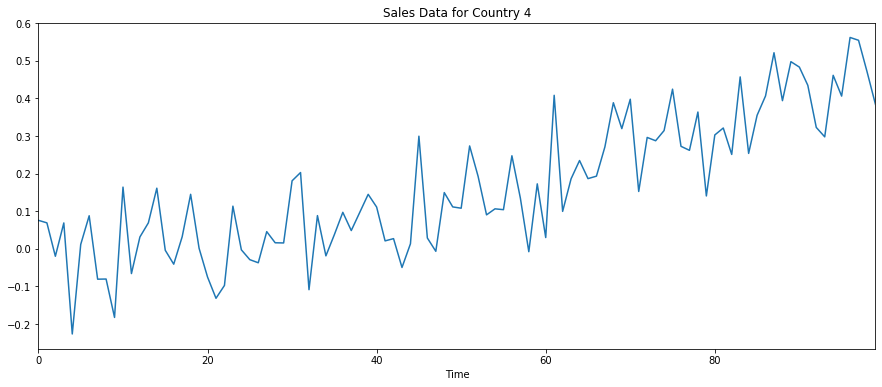

In [221]:
periodic_freq = 4
country_id = 4

ax = data.iloc[country_id,1:101].plot(figsize = (15,6), title=f"Sales Data for Country {country_id}", legend = False)
ax.set(xlabel="Time")
plt.show()

The above plot shows the sales data, unaltered for a single country. We can observe an upward trend over time. The jaggedness of the data may indicate a periodic component. The following sections aim to discover if that is the case. 

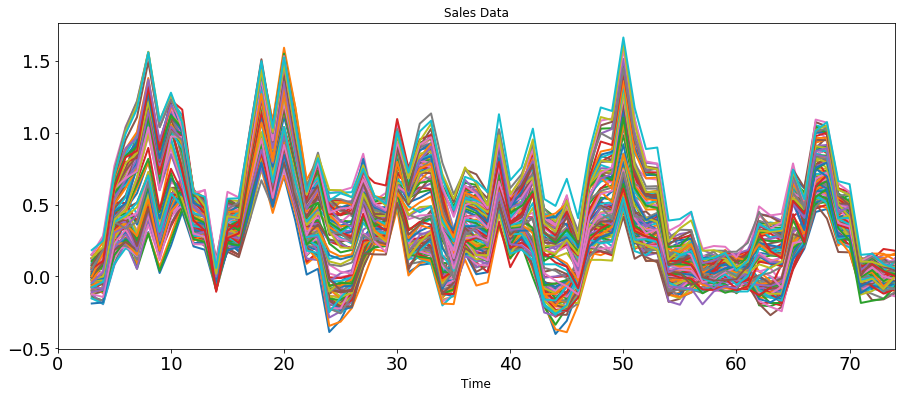

In [222]:
sales_all = data.iloc[:,1:101]
sales_all.rolling(periodic_freq).mean().plot(figsize = (15,6), title="Sales Data", linewidth=2, fontsize=18, legend = False)
plt.xlabel('Time', fontsize=12);
plt.show()

Tried to find out first, if there is a periodic cycle in the data and if so what is it's frequency. 
* 365 - Days
 * Resulted in no data meaning not a daily period
* 52 - Weeks
 * Resulted in some results but not over the entire series
* 12 - Months
 * Resulted in something started to form here but still not complete
* 4 - Seasons (Summer, Autumn, Winter, Spring)
 * Got a much longer trend forming across the data indicating seasonality is present
* 2 - Seasons (Summer, Winter)
 * Got a similar view, difficult to tell between full seasons or short seasons

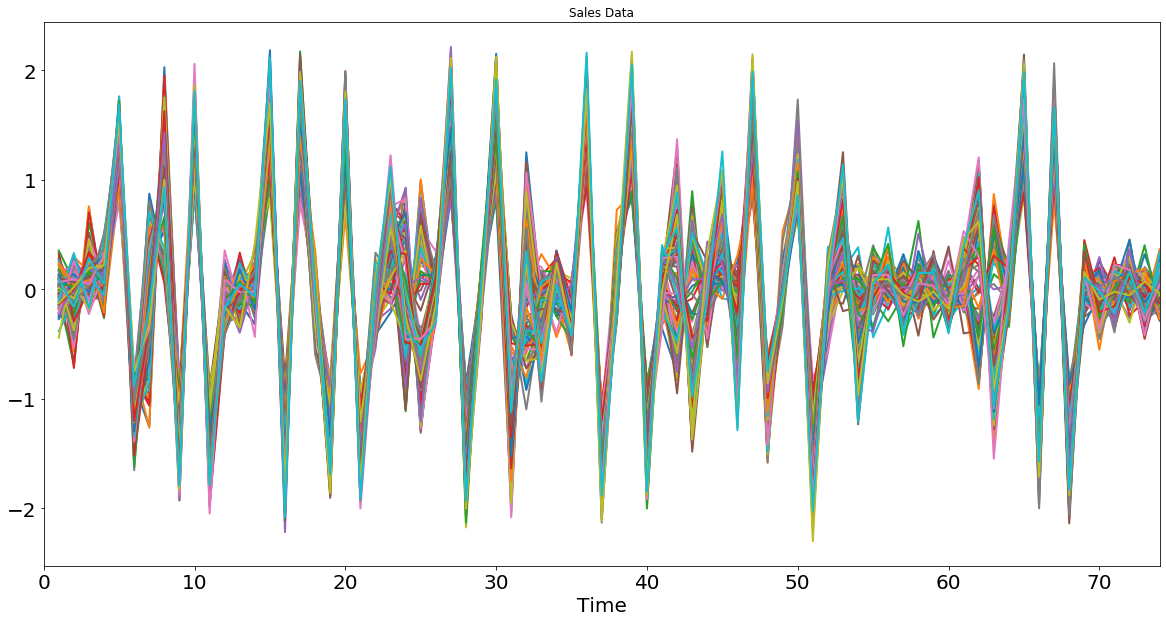

In [223]:
sales_all.diff().plot(figsize=(20,10), title="Sales Data", linewidth=2, fontsize=20, legend=False)
plt.xlabel('Time', fontsize=20);

By removing the trend from the data we can see a very clear pattern of highs and lows. This would lead us to believe that there is in fact periodicity in the data. Due to the pattern extreme high followed by extreme low we've deduced that the seasonality is dual in nature. 

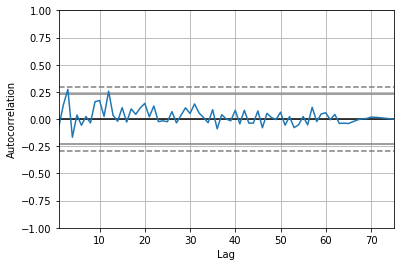

In [224]:
pd.plotting.autocorrelation_plot(sales_all)

Auto correlation plot look for randomness in the data. This is done by computing autocorrelations for data values at varying time lags. The dotted lines indicate 95% confidence. 

TODO vrify that since the plot does not exceed the 95% threshold the values for sales figures are not correlated. Or put another way, the sales figures collected on one day have no dependence on those collected on the previous day. 

# Stationary Time Series
Now that we have concluded that a seasonal periodic pattern exists, and what we believe the frequency to be, in the data we want to remove it. In other words, we want our time series to be stationary. 

A stationary time series is...... TODO defnition

We'll take another looks at the data, this time for a single country.

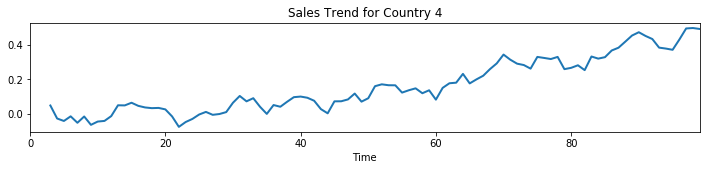

In [225]:
sales = data.iloc[country_id,1:101]
sales.rolling(periodic_freq).mean().plot(figsize = (12,2), title=f"Sales Trend for Country {country_id}", linewidth=2, legend = False)
plt.xlabel('Time');
plt.show()

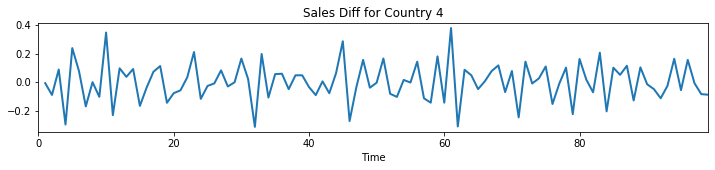

In [226]:
sales.diff().plot(figsize=(12,2), title=f"Sales Diff for Country {country_id}", linewidth=2, legend=False)
plt.xlabel('Time');

Here we are looking at the same plots as above, except focusing on a single country. These are shown to justify our choice below to use statsmodels seasonal_decompose function. In comparison we can see that the trend and residual sections line up with our Sales Trend and Sales Diff plots.  

From here on we will use statsmodels functions to identify the trends in the data. 

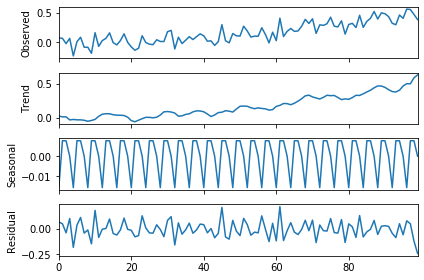

In [227]:
decomp_single = seasonal_decompose(data.iloc[country_id,1:101].T, model='additive', freq=periodic_freq, extrapolate_trend='freq')
decomp_single.plot()
plt.show()

From this plot we can see a couple of interesting elements: 
* Observed - This shows us the values observed for this country over time, unaltered
* Trend - We can conclude from above that this view is also generated using a rolling mean
* Seasonal - The interesting point here is the very small range that the seasonality covers, only +- 0.0025
* Residual - Follows a similar pattern to the difference plot which we used to see a periodic pattern in the data

# Modeling the Trend
Now that we have methods for identifying a trend in the data we will attempt to model it. Firstly we will continue with the same country shown above. 

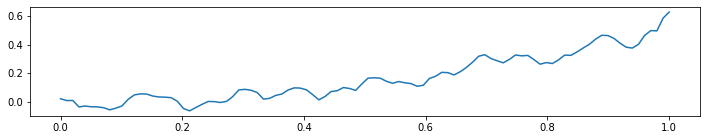

In [228]:
X = np.linspace(0,1,100)[:, None]
Y = decomp_single.trend[:, None]
plt.figure(figsize=(12, 2))
plt.plot(X,Y)

The trend data shown over a standardized [0,1] space

In [289]:
def model_kernel():
    '''
    Helper function that will allow the same kernel to be used elsewhere
    '''
    
    ker1 = GPy.kern.Matern52(1)
    ker2 = GPy.kern.ExpQuad(1)
    ker3 = GPy.kern.Linear(1)
    
    kernel = ker1*ker3
    return kernel

This method served as a bit of a focal point for efforts. The goal here was to model the data by way of one or more covariance functions (kernels). Each kernel has different properties that fit to different patterns. 

TODO: This section is important. Try to bring it together from others notebooks. 

Optimization restart 1/20, f = -173.2842567910881
Optimization restart 2/20, f = -220.42472562709477
Optimization restart 3/20, f = -173.28425678762864
Optimization restart 4/20, f = -173.28425676026274
Optimization restart 5/20, f = -173.28425675968182
Optimization restart 6/20, f = -173.2842567526314
Optimization restart 7/20, f = -220.42472562764027
Optimization restart 8/20, f = -173.2842567908846
Optimization restart 9/20, f = -173.2842567659115
Optimization restart 10/20, f = -220.42472562764027
Optimization restart 11/20, f = -173.28425679125235
Optimization restart 12/20, f = -220.42472562754537
Optimization restart 13/20, f = -220.4247256276331
Optimization restart 14/20, f = -220.42472562764965
Optimization restart 15/20, f = -220.42472562752096
Optimization restart 16/20, f = -173.28425677910593
Optimization restart 17/20, f = -173.28425679098427
Optimization restart 18/20, f = -173.28425679111018
Optimization restart 19/20, f = -173.28425679120642
Optimization restart 20/20

GP_regression.,value,constraints,priors
mul.Mat52.variance,0.7688458350900979,+ve,
mul.Mat52.lengthscale,0.054990956060019545,+ve,
mul.linear.variances,0.15291830616970156,+ve,
Gaussian_noise.variance,9.554944951743155e-05,+ve,


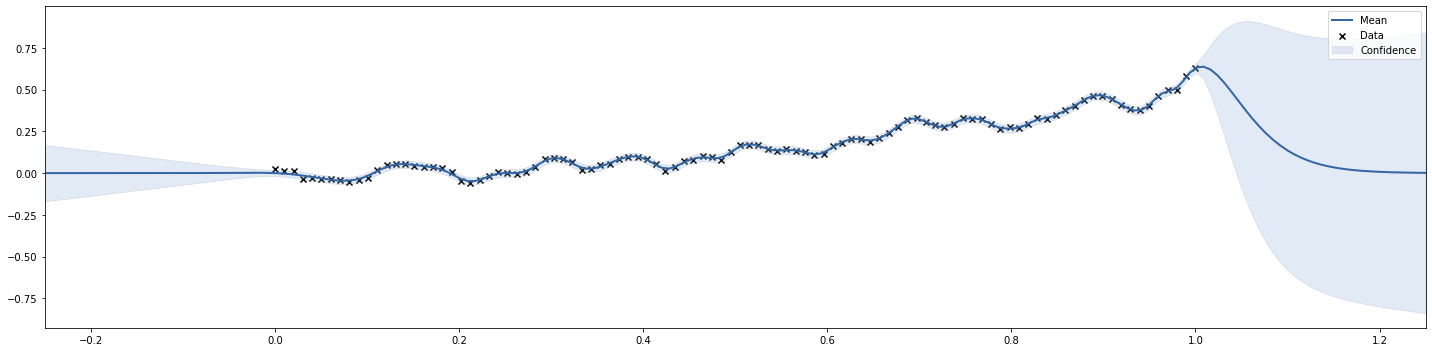

In [290]:
# Create our model and optomize the parameters
kernel = model_kernel()
s_model = GPy.models.GPRegression(X,Y,kernel=kernel)
s_model.optimize_restarts(20, robust=True, verbose=True, parallel=True, num_processes=12)

# Plot the results
fig = s_model.plot(figsize=(20,5))
display(s_model)

## GPy Model Output
Here we can see the output from our generated model. The points are the observed data that we passed in, an evenly spaces series of values between 0 & 1. The line is the mean value of the data and the shaded area is our confidence level.

An interesting aspect is how the area widens the further away we get from the observed points. 

TODO: More to fill in as to explaination  

# Training
Using a number of single examples we attempted to model the data. With that in place we started training against the test set, verifying our results against the labels provided to us. 

In [291]:
def run_model(x_in, y_in):
    '''
    Will run a model using the kernel defined earlier. Sampling will then allow us to 
    calculate the posterior probability that the sales trend is increasing for the given country
    '''

    kernel = model_kernel()
    model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)
    model.optimize_restarts(20, robust=True, verbose=False, parallel=True, num_processes=12)
    
    # Generate a new set of X values, evenly spaced between 0,1
    x_new = X = np.linspace(0,1,100).reshape(-1,1)
    
    # Get the posterior distribution and sample
    f_pred, sigm_pred = model.predict_noiseless(x_new, full_cov=True, kern=kernel)
    Z = np.random.multivariate_normal(f_pred.T[0], sigm_pred, 1000).T
    
    posterior_der_pos = (np.diff(np.mean(Z.T,axis=0), 1)>0).sum()/len(np.mean(Z.T,axis=0))
    
    if posterior_der_pos>0.95:
        return 1
    else:
        return 0

# Training Data
Before applying our model to unseen data, we train and validate against known training data with set labels

In [292]:
num_rows = 5
actual = data.iloc[0:num_rows, -1]
predicted = []
x_d = np.linspace(0,1,100)[:, None]
for x in range(num_rows):
    print(f'Iteration: {x+1} of {num_rows}')
    decomp = seasonal_decompose(data.iloc[x,1:101].T, model='additive', freq=periodic_freq, extrapolate_trend='freq')
    y_d = decomp.trend.values[:, None]
    decision = run_model(x_d,y_d)
    predicted.append(decision)

Iteration: 1 of 5
Iteration: 2 of 5
Iteration: 3 of 5
Iteration: 4 of 5
Iteration: 5 of 5


# Results
Training complete we can now review our accuracy to determine how well our model performed

In [293]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

print(predicted)
results = confusion_matrix(actual, predicted) 
print(results)
print(f'Accuracy Score: {accuracy_score(actual, predicted)}')
print('The Report:')
print(classification_report(actual, predicted))

[0, 0, 0, 0, 0]
[[3 0]
 [2 0]]
Accuracy Score: 0.6
The Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5



# Unseen
Once we are happy with the performance of our model we can use it against the unseen dataset. This is a true measure of how well we have modeled our data.

In [184]:
allow_test = True
if allow_test:
    test_df = pd.read_csv("./data/test.csv")
    rows = test_df.shape[0]
    x_t = np.linspace(0,1,100)[:, None]
    
    Decision = pd.DataFrame(columns=['Id','Category'])
    for r in range(rows):
        print(f'Iteration: {r+1} of {rows}')
        id_row = test_df.iloc[r,0]
        decomp_t = seasonal_decompose(test_df.iloc[x,1:101].T, model='additive', freq=2, extrapolate_trend='freq')
        y_t = decomp_t.trend.values[:, None]
        decision = run_model(x_t,y_t)
        print(f'Decision is {decision} for Id {id_row}')
        Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 

    Decision.to_csv('submission.csv', index=False)

Iteration: 1 of 120
Decision is 0 for Id 0
Iteration: 2 of 120
Decision is 0 for Id 1
Iteration: 3 of 120
Decision is 0 for Id 2
Iteration: 4 of 120
Decision is 0 for Id 3
Iteration: 5 of 120
Decision is 0 for Id 4
Iteration: 6 of 120
Decision is 0 for Id 5
Iteration: 7 of 120
Decision is 0 for Id 6
Iteration: 8 of 120
Decision is 0 for Id 7
Iteration: 9 of 120
Decision is 0 for Id 8
Iteration: 10 of 120
Decision is 0 for Id 9
Iteration: 11 of 120
Decision is 0 for Id 10
Iteration: 12 of 120
Decision is 0 for Id 11
Iteration: 13 of 120
Decision is 0 for Id 12
Iteration: 14 of 120
Decision is 0 for Id 13
Iteration: 15 of 120
Decision is 0 for Id 14
Iteration: 16 of 120
Decision is 0 for Id 15
Iteration: 17 of 120
Decision is 0 for Id 16
Iteration: 18 of 120
Decision is 0 for Id 17
Iteration: 19 of 120
Decision is 0 for Id 18
Iteration: 20 of 120
Decision is 0 for Id 19
Iteration: 21 of 120
Decision is 0 for Id 20
Iteration: 22 of 120
Decision is 0 for Id 21
Iteration: 23 of 120
Decision